# Project 3: Web APIs & NLP

# Evaluation Notebook

In this notebook, we will evaluate the models we had previously created and generate some visualizations to aid our evaluation. Due to this problem being of a classification nature, confusion matrix would allow us to observe how many of our predictions are actually accurate when compared against the real data. Furthermore from the confusion matrix, we can expand into ROC curves to evaluate how good our model is at predicting each side of the classification. Finally, we will also visualize some of the key features that is highlighted by our models and see if they all share the same top features.

---

### Problem Statement ###

Here we have a set of data taken from `r/LifeProTips` and `r/YouShouldKnow`. These subreddits both contain similar posts which are typically useful factoids in nature. These are also generally random and very varied in terms of information provided. We will attempt to generate NLP models to sort the posts into their respective categories. We will share these findings with our fellow data scientists for peer review.

---

### Methodology ###

In the <a href="./Data Collection.ipynb">Data Collection</a> sheet, we scraped reddit posts using pushshift API. Subsequently, we clean the data and export it to create a fair set of data for modelling. In it we removed several crucial information such as the post tags `LPT` and `YSK` which stands for `LifeProTips` and `YouShouldKnow` respectively. We also removed URLs to avoid adding unnecessary words into our vectorizer.

In the <a href="./Modelling.ipynb">Modelling</a> sheet, we generated 5 different models (_Random Forest, Boosted Stumps, Logistic Regression, Multinomial Naive Bayes and Stacking Classifier_) and had a peek of their results. It is also in this sheet where we manually start adding some words to feed into our vectorizer in order to make our model as fair as possible. This, overall, reduced their accuracy but we feel that this would make it more robust when encountering unknown data.

Finally in this sheet, we will evaluate our models. These models will be primarily evaluated on their accuracy scores and their respective recall and specificity score in the form of ROC plots. Comparison of the baseline against the ROC plot will be showed at a threshold of 0.50 for the baseline (i.e. 50-50 coin flip). A secondary evaluation will be conducted on the top 20 features, to observe how significant the features are at sorting between the two categories.

---

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import bz2


#downgrade sklearn to 0.23.2 since the models were modelled in that version.
#!pip install scikit-learn==0.23.2 --upgrade --user

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

rs = 0 #random state

### Functions for Ease of Implementation

In [2]:
def load(file): # Create function to load our model
    file = bz2.BZ2File(f'./models/{file}.p', 'rb')
    model = pickle.load(file)
    return model

def save(thing, thing_name): # save anything
    sfile = bz2.BZ2File(f'./models/{thing_name}.p', 'wb')
    pickle.dump(thing, sfile)

def scorer(model): # Scores the model via confusion matrix and classification report
    # Get predictions
    preds = model.predict(X_test_v)
    
    with sns.axes_style(style="white"):
        plot_confusion_matrix(model, X_test_v, y_test, cmap='GnBu', values_format='d',display_labels={'LifeProTips':1,'YouShouldKnow':0});

    print("Training Score:",model.score(X_train_v,y_train))
    print("Testing Score:",model.score(X_test_v,y_test))
    print("\n")
    print(classification_report(y_test, preds))   
    
def fimportance(scores): # Plot top 20 feature importance/coefficients as horizontal bar plot
    
    # Initialize the matplotlib figure
    df = scores.sort_values("feature_importance",ascending=False).head(20)
    
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(8, 12))
        
        # Plot the features
        sns.set_color_codes("muted")
        hbar = sns.barplot(x="feature_importance",
                            y="feature",
                            data=df,
                            color="b")
        
    for bar in hbar.patches:
   
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_width()
        # y-coordinate: bar.get_y()+bar.get_height()/2
        # free space to be left to make graph pleasing: (0, 0)
        # ha and va stand for the horizontal and vertical alignment
        hbar.annotate(format(bar.get_width(), '.3f'),
                      (bar.get_width(), bar.get_y()+bar.get_height()/2), ha='left', va='center',
                       size=10, xytext=(2, 0),
                       textcoords='offset points')

    # Add axis label
    ax.set(xlabel="Feature Importance") # For convenience we will also label coefficients as feature importance
    sns.despine(left=True, bottom=True)

#def roc(model): # generate ROC curve
 #   preds = model.predict(X_test_v) 
  #  fpr, tpr, _ = roc_curve(y_test, preds)
   # with sns.axes_style(style="darkgrid"):
    #    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
     #   
    #sns.despine(left=True,bottom=True)

def roc(model,model_name): # generate ROC curve
    df = pd.DataFrame(model.predict_proba(X_test_v))
    preds = df.drop(columns=0)
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,label="%s, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(y_test,y_test,color='orange',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    sns.despine(left=True,bottom=True)

### Train Test Split & Count Vectorizer

In order to keep our results consistent, we will perform train test split and count vectorizer with the codes copied from the modelling notebook. Additional stop words were added after previous modelling processes yields words that are not significant.

_Notes from Modelling Notebook:
Here we set the X and y prior to splitting and modelling. X is made up of the concatenated text between `title` and `selftext` that has been cleaned in the data collection notebook. We then proceed to convert the data into a bag of words via count vectorizer._

In [3]:
# Copied data processing from previous notebook

df = pd.read_csv('./dataset/data.csv')

X = df['text']
y = df['subreddit'].map({'LifeProTips':1,'YouShouldKnow':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=rs)

stopwords=[]
for i in CountVectorizer(stop_words = 'english').get_stop_words():
    stopwords.append(i)
    
#add additional stop words based on previous cycles of this process below
extrawords = ['https','com','www','don', 'org','http','ll','gt','ve','edit','really'] 
for i in extrawords:
    stopwords.append(i)

cvec=  CountVectorizer(stop_words=stopwords, max_df=0.7, ngram_range=(1,4), min_df=2, max_features=50_000)

X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.transform(X_test)

### Load Models Created in Modelling Notebook

In [4]:
fname = load("fname") #List of feature names

rf = load("rf") # Random Forest model
bs = load("bs") # Adaboosted Stumps model
lr = load("lr") # Logistic Regression model
nb = load("nb") # Multinomial Naive Bayes model
sm = load("sm") # Stacked Classifier model
baseline = load("baseline") # Baseline Random Forest Model

C:\Users\65908\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\65908\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\65908\anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid r

### Baseline Random Forest Model

The first model created with default random forest model. Even without hyperparameter tuning, the scores are relatively high compared to other models at 77%. Recall score is slightly higher for predicting `YouShouldKnow` than predicting `LifeProTips`.

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Score: 0.9990838295923041
Testing Score: 0.7706043956043956


              precision    recall  f1-score   support

           0       0.81      0.71      0.75       360
           1       0.74      0.83      0.79       368

    accuracy                           0.77       728
   macro avg       0.77      0.77      0.77       728
weighted avg       0.77      0.77      0.77       728



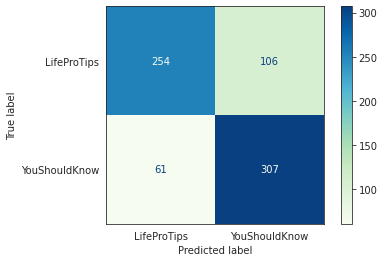

In [5]:
scorer(baseline)

Our ROC plot is above the 50% line, with an AuC that is significantly higher than 0.5.

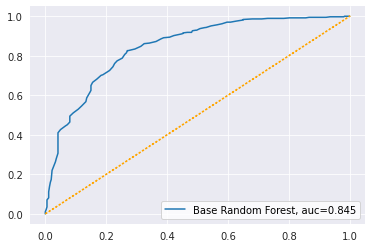

In [6]:
roc(baseline,"Base Random Forest")

In [7]:
base_importance = zip(fname, baseline.feature_importances_)
base_df = pd.DataFrame(base_importance,columns=['feature','feature_importance'])
base_df = base_df.sort_values("feature_importance",ascending=False).reset_index(drop=True)
base_df.head()

,feature,feature_importance
0,shared,0.008004
1,explaining,0.006663
2,center,0.003268
3,hotline,0.003224
4,miles,0.003066


There are several key feature importance related to internet terms such as 'website', 'google', 'amazon', 'link', 'data' and 'site'.

Note that despite setting up count vectorizer n-gram between 1 and 4, all of the top 20 features are single words. This further isolates the features as individual abstract terms rather than key phrases which may be identified within a particular subreddit.

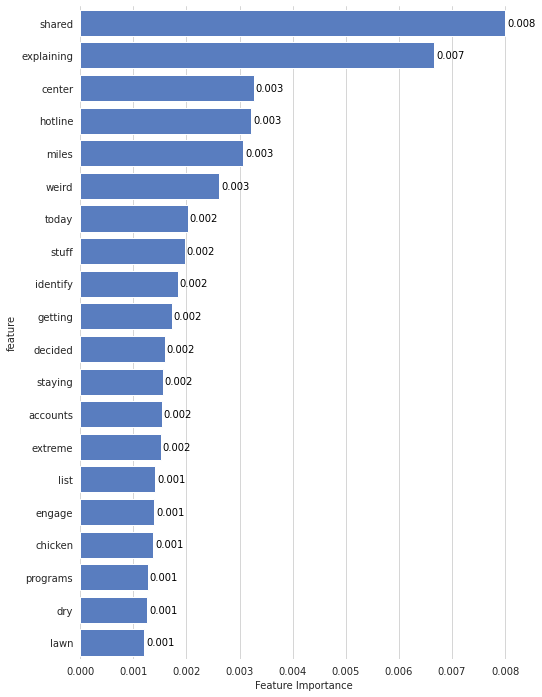

In [8]:
fimportance(base_df)

### Random Forest

Hyperparameter tuning of the baseline model via GridSearch CV in fact yields slightly better results at 79% accuracy. As shown in the confusion matrix below, there is a general increase of recall scores for both `LifeProTips` and `YouShouldKnow`.

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Score: 0.9990838295923041
Testing Score: 0.7884615384615384


              precision    recall  f1-score   support

           0       0.83      0.72      0.77       360
           1       0.76      0.85      0.80       368

    accuracy                           0.79       728
   macro avg       0.79      0.79      0.79       728
weighted avg       0.79      0.79      0.79       728



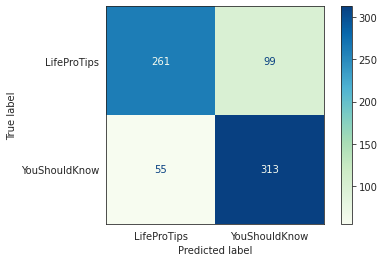

In [9]:
scorer(rf)

The ROC curve performs slightly better compared to the baseline random forest at a higher AuC of 0.863.

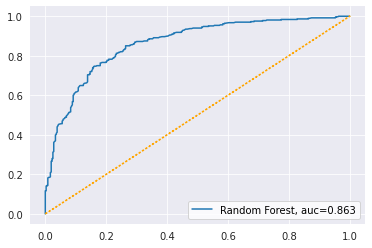

In [10]:
roc(rf,"Random Forest")

In [11]:
rf_importance = zip(fname, rf.best_estimator_.feature_importances_)
rf_df = pd.DataFrame(rf_importance,columns=['feature','feature_importance'])
rf_df = rf_df.sort_values("feature_importance",ascending=False).reset_index(drop=True)
rf_df.head()

,feature,feature_importance
0,shared,0.003096
1,explaining,0.002287
2,identify,0.001418
3,stuff,0.001334
4,getting,0.001247


Feature importance of our tuned random forest is similar to the baseline model. Majority of the top features are shared between the two models. All of the features are also single words, suggesting that common phrases may be common to both `LifeProTips` and `YouShouldKnow`.

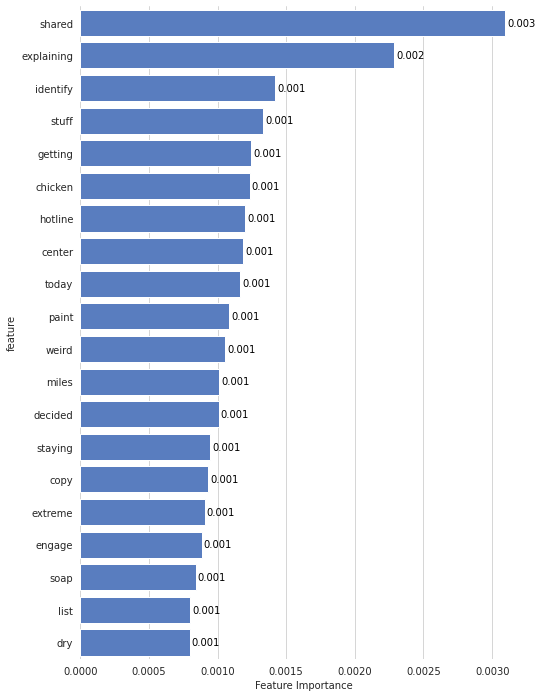

In [12]:
fimportance(rf_df)

### Boosted Trees

The AdaBoost model here uses the default setting of using decision tree stumps as its estimators. Accuracy of the model is about 9% lower than our tuned random forest model.

Recall score for `LifeProTips` is slightly lower than the random forest models, and the recall score for `YouShouldKnow` is significantly lower at 64%. This is probably why our overall accuracy drops compared to our previous models.

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Score: 0.9015116811726981
Testing Score: 0.7046703296703297


              precision    recall  f1-score   support

           0       0.73      0.64      0.68       360
           1       0.68      0.77      0.73       368

    accuracy                           0.70       728
   macro avg       0.71      0.70      0.70       728
weighted avg       0.71      0.70      0.70       728



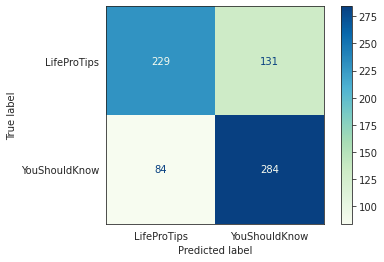

In [13]:
scorer(bs)

The ROC slope is more gradual and the area under the curve is less compared to the previous models, in line with the lower accuracy score.

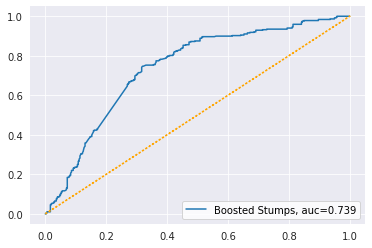

In [14]:
roc(bs, "Boosted Stumps")

In [15]:
bs_importance = zip(fname, bs.best_estimator_.feature_importances_)
bs_df = pd.DataFrame(bs_importance,columns=['feature','feature_importance'])
bs_df.sort_values("feature_importance",ascending=False).head()

,feature,feature_importance
674,explaining,0.008
2128,weird,0.008
682,extreme,0.008
1639,save life,0.004
478,daily,0.004


Feature importance among the stumps are rather uniform since there is only 1 node per tree. Similar to our random forest models, there are plenty of internet-related terms among the top features. However one of the top results here, 'water', does not exist in among the top 20 features of our random forest models.

In this case, the random forest model is better in terms of estimating feature importance as they are calculated with a full tree, rather than stumps. The node probabilities are more refined as each impurity is weighted, as opposed to the boosted stumps approach where there is only a single node on a tree and results are penalized rather than aggregated.

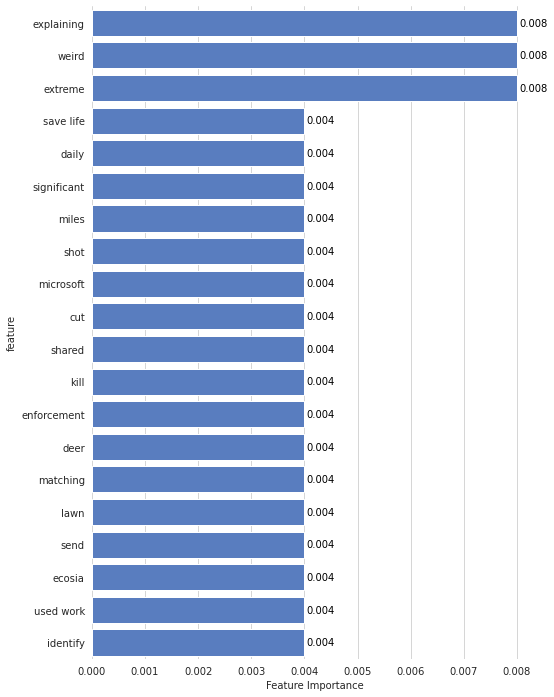

In [16]:
fimportance(bs_df)

### Logistic Regression

The logistic regression model also performs fairly well at 78% accuracy. What separates this model from the other models thus far is that the recall score of `LifeProTips` is slightly higher at 0.85. In contrast, however, recall score for `YouShouldKnow` is lower at 0.70, hence averaging out the accuracy score at 0.78. This means that if we are exclusively looking to predict `LifeProTips`, then this is the model to go to.

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Score: 0.9949610627576729
Testing Score: 0.7760989010989011


              precision    recall  f1-score   support

           0       0.82      0.70      0.76       360
           1       0.74      0.85      0.79       368

    accuracy                           0.78       728
   macro avg       0.78      0.78      0.77       728
weighted avg       0.78      0.78      0.77       728



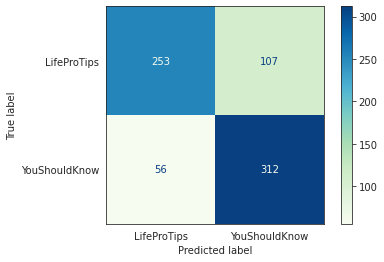

In [17]:
scorer(lr)

The AuC is significantly higher than the baseline, but not higher than our random forest models.

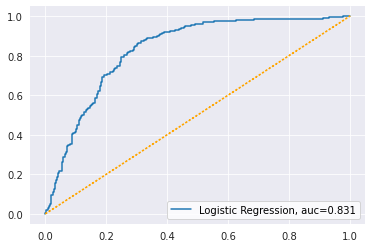

In [18]:
roc(lr,"Logistic Regression")

In [19]:
lr_unpack = [val for sublist in lr.best_estimator_.coef_ for val in sublist]
lr_importance = zip(fname, lr_unpack)
lr_df = pd.DataFrame(lr_importance,columns=['feature','feature_importance'])
lr_df.sort_values("feature_importance",ascending=False).head()

,feature,feature_importance
2128,weird,1.040767
1021,kill,0.860672
1234,moving,0.793615
1639,save life,0.739390
881,helped,0.668174


Feature coefficients of the model suggests a slightly different set of words compared to our tree-based models thus far. There are two 2 ngram features highlighted among the top 20: 'open source' and 'phone number'.

There are several internet-related terms such as 'facebook', 'open source' and 'websites', but note that these are not among the top 20 of the tree-based models. Furthermore, prior commonly shared features such as 'google', 'reddit', 'amazon' and 'link' are not found on this list.

Another interesting observation is that this list picked up 'websites' among the top 20, while the forest models picked up 'website'. This can be rectified in the future by manually replacing similar words or using a different word processing method.

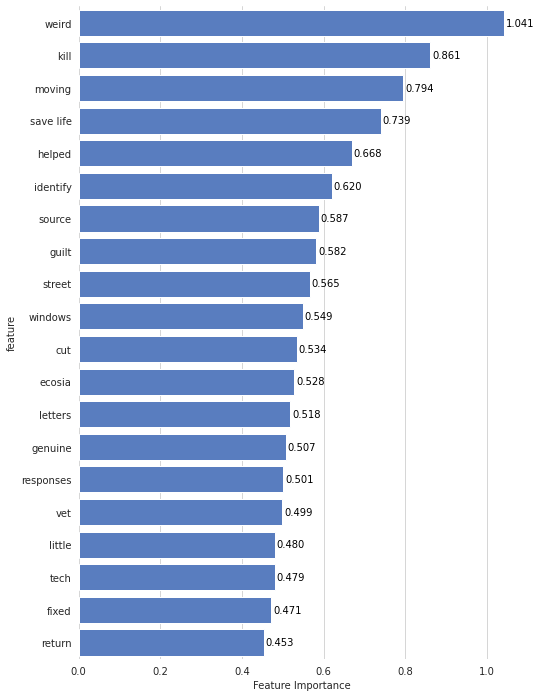

In [20]:
fimportance(lr_df)

### Multinomial Naive Bayes

The Multinomial Naive Bayes model also perform rather well, scoring accuracy at 0.75. Similar to the logistic regression model, it is slightly better at predicting `YouShouldKnow` than it is at predicting `LifeProTips`. Recall score for `LifeProTips` is at 0.75, while its specificity is 0.76. This model is the best at predicting `YouShouldKnow` thus far.

Training Score: 0.9473202015574896
Testing Score: 0.7541208791208791


              precision    recall  f1-score   support

           0       0.75      0.76      0.75       360
           1       0.76      0.75      0.75       368

    accuracy                           0.75       728
   macro avg       0.75      0.75      0.75       728
weighted avg       0.75      0.75      0.75       728



C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


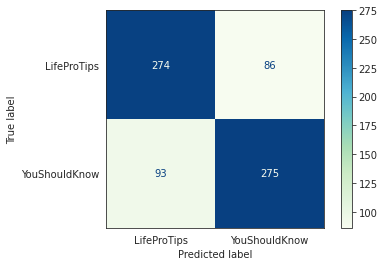

In [21]:
scorer(nb)

The AuC is still lower than our random forest models, but higher than Boosted Stumps.

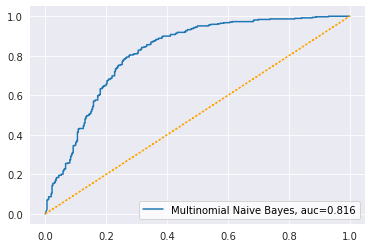

In [22]:
roc(nb,"Multinomial Naive Bayes")

In [23]:
nb_unpack = [val for sublist in nb.best_estimator_.coef_ for val in sublist]
nb_importance = zip(fname, nb_unpack)
nb_df = pd.DataFrame(nb_importance,columns=['feature','feature_importance'])
nb_df['feature_importance'] = nb_df["feature_importance"].map(lambda x: np.exp(x))
nb_df.sort_values("feature_importance",ascending=False).head()

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,feature_importance
931,identify,0.002984
1321,paint,0.002523
687,facebook,0.002216
1762,soap,0.001970
1662,seat,0.001786


Interestingly, among the rest of the models, this one picked the most abstract and different set of top features. There are a lot more verbs picked up compared to other models, and no internet-related terms.

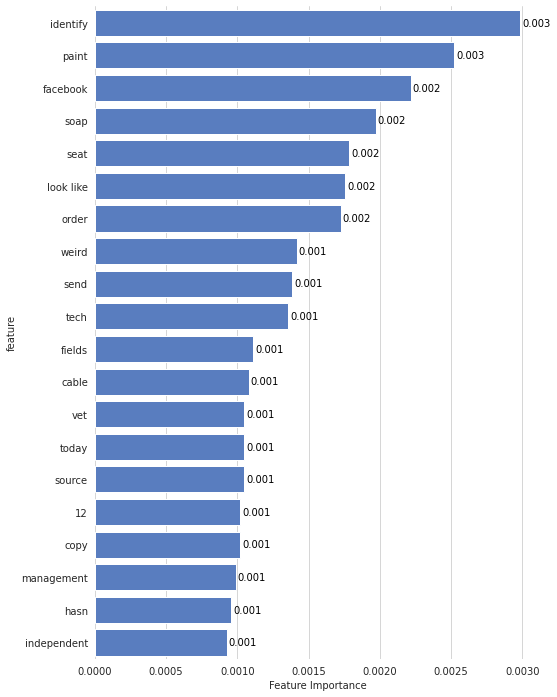

In [24]:
fimportance(nb_df)

### Stacked Model

Since all previous models have rather weak coefficient scores and feature importances between all the words, it is perhaps better to aggregate them in a single stacked model. In this case, we wrapped up our 4 existing models in the stack model with logistic regression as its final estimator.

The results show that is it the best performing model so far at 80% accuracy. Furthermore, recall scores for both `LifeProTips` and `YouShouldKnow` are quite close and balanced at 0.82 and 0.79 compared to previous models.

C:\Users\65908\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Score: 0.9990838295923041
Testing Score: 0.8021978021978022


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       360
           1       0.80      0.82      0.81       368

    accuracy                           0.80       728
   macro avg       0.80      0.80      0.80       728
weighted avg       0.80      0.80      0.80       728



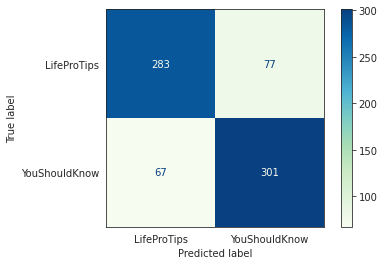

In [25]:
scorer(sm)

The accuracy score of the Stacking Classifier is the highest among the models. Furthermore, the AuC is also the highest, and the slope is the steepest at the start.

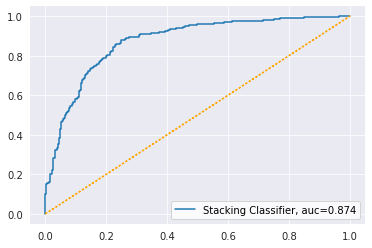

In [26]:
roc(sm,"Stacking Classifier")

In [27]:
sm_unpack = [val for sublist in sm.best_estimator_.final_estimator_.coef_ for val in sublist]
sm_importance = zip(['Random Forest','Boosted Trees','Logistic Regression','Multinomial Naive Bayes'], sm_unpack)
sm_df = pd.DataFrame(sm_importance,columns=['estimator','estimator_score'])
sm_df.sort_values("estimator_score",ascending=False).head()

,estimator,estimator_score
0,Random Forest,5.692922
2,Logistic Regression,0.824498
3,Multinomial Naive Bayes,0.706074
1,Boosted Trees,0.460867


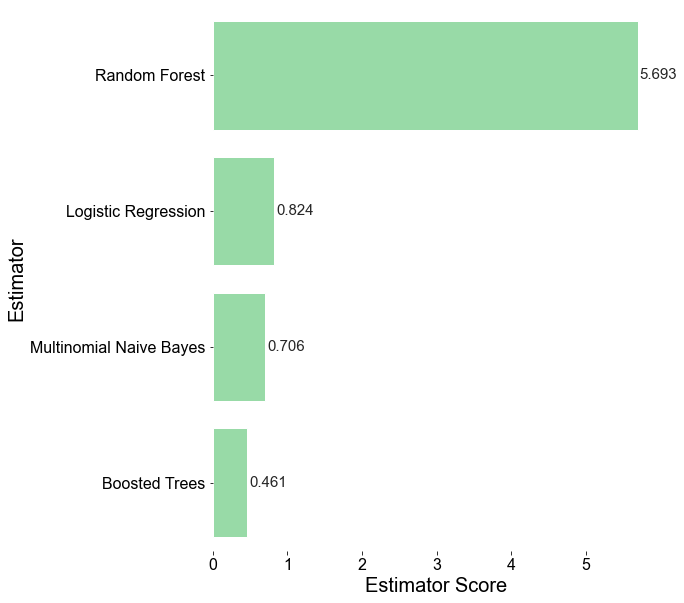

In [28]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))
sns.set_theme(style="whitegrid")
# Plot the features
sns.set_color_codes("pastel")
hbar = sns.barplot(x="estimator_score", y="estimator", data=sm_df.sort_values("estimator_score",ascending=False), color="g")

# Add informative axis label
#ax.set(ylabel="Estimator",
#       xlabel="Estimator Score")
plt.xlabel('Estimator Score', fontsize=20)
plt.ylabel('Estimator', fontsize=20)

for bar in hbar.patches:
   
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_width()
        # y-coordinate: bar.get_y()+bar.get_height()/2
        # free space to be left to make graph pleasing: (0, 0)
        # ha and va stand for the horizontal and vertical alignment
        hbar.annotate(format(bar.get_width(), '.3f'),
                      (bar.get_width(), bar.get_y()+bar.get_height()/2), ha='left', va='center',
                       size=15, xytext=(2, 0),
                       textcoords='offset points')
        
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
        
sns.despine(left=True, bottom=True)

### Conclusion

With these models, we can conclude that the stack model performs the best with a higher accuracy. Recall and Specificity are the highest among the models (except logistics regression recall score) and are relatively balanced.

Unfortunately I was unable to decode the entirety of the stacked model during the duration of the project, but that is an area of future studies.

Overall the project was a difficult one. With similar contents both coming from `LifeProTips` and `YouShouldKnow`, we were only able to generate a model that peaks at 80% accuracy.

### Future Recommendations

For future recommendations, two steps could be taken. Firstly is to try other types of models and see if they can fit better. Secondly is to tune the parameters of our best model. With more resources, we could include different vectorization methods, run a gridsearch on the vectorizing transform on top of the modelling, or even perform a stacked model on these pipelines.

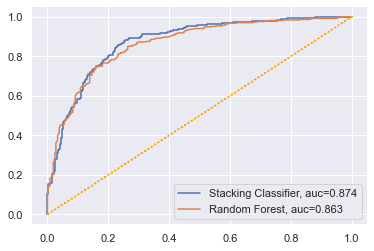

In [29]:
# Image comparison for slides only
with sns.axes_style(style="darkgrid"):

    smdf = pd.DataFrame(sm.predict_proba(X_test_v))
    preds = smdf.drop(columns=0)
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="Stacking Classifier, auc="+format(auc,'.3f'))

    rfdf = pd.DataFrame(rf.predict_proba(X_test_v))
    preds = rfdf.drop(columns=0)
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="Random Forest, auc="+format(auc,'.3f'))
    
    plt.plot(y_test,y_test,color='orange',linestyle=':')

    plt.legend(loc=0)
    sns.despine(left=True,bottom=True)

In [30]:
fname

['00',
 '10',
 '10 years',
 '100',
 '1000',
 '11',
 '12',
 '15',
 '16',
 '18',
 '1k',
 '20',
 '200',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '24',
 '24 hours',
 '25',
 '30',
 '300',
 '40',
 '4th',
 '50',
 '500',
 '60',
 '70',
 '80',
 '800',
 '90',
 '911',
 '99',
 'ability',
 'able',
 'absolutely',
 'abuse',
 'accept',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'according',
 'account',
 'accounts',
 'accurate',
 'accurately',
 'act',
 'acting',
 'action',
 'actions',
 'active',
 'actively',
 'activity',
 'actual',
 'actually',
 'ad',
 'ada',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'addresses',
 'adds',
 'adjust',
 'ads',
 'adult',
 'adults',
 'advantage',
 'advertised',
 'advice',
 'affect',
 'affected',
 'afford',
 'afraid',
 'age',
 'agencies',
 'agency',
 'agent',
 'aggressive',
 'ago',
 'agree',
 'agreement',
 'ahead',
 'aid',
 'air',
 'airline',
 'airlines',
 'airport',
 'aisle',
 'alarm',
 'alcohol',
 'alert',
 'ale